### Boilerplate

In [1]:
from bs4 import BeautifulSoup
import pandas as pd

import pyspark.sql.functions as F

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
from IPython.display import Image
InteractiveShell.ast_node_interactivity = "all"
display(HTML('<style>.container {width:90% !important;}</style>'))

spark.sql('CREATE DATABASE IF NOT EXISTS football_games')
spark.sql('USE football_games')

DataFrame[]

### Write to Postgres for SQL Alchemy ER Diagram

#### Dependencies on Mac, assuming postgres is installed and running

In [2]:
# !brew install postgres
# !brew services start postgresql
# !conda install -y psycopg2 graphviz
# !brew install eralchemy
# !pip install eralchemy

# !alias python3=/usr/local/Cellar/eralchemy/1.2.10_1/libexec/bin/python3.7
# !cd /tmp
# !git clone https://github.com/psycopg/psycopg2.git
# !cd psycopg2/
# !python3 setup.py build
# !python3 setup.py install
# !brew install openssl@1.1

In [3]:
from sqlalchemy import create_engine

db_string = "postgres://joshplotkin@localhost:5432/postgres"
db = create_engine(db_string, isolation_level="AUTOCOMMIT")
_ = db.execute('DROP DATABASE IF EXISTS football_data')
_ = db.execute('CREATE DATABASE football_data')

In [4]:
db_string = "postgres://joshplotkin@localhost:5432/football_data"
db = create_engine(db_string, isolation_level="AUTOCOMMIT")

#### Write tables to postgres, with primary key

In [5]:
tables = [
    ('team_season', ['season','team_id']),
    ('coach', ['coach_id']),
    ('stadium', ['stadium']),
    ('game_line', ['game_id']),
    ('game_outcome', ['game_id']),
    ('game_metadata', ['game_id']),
    ('game', ['game_id']),
    ('dvoa', ['team_id', 'season', 'week_id']),
]

for tbl, key in tables:
    tmp = spark.table(tbl).toPandas().set_index(key)
    ## write pandas DF to Postgres Table
    tmp.to_sql(tbl, con=db, if_exists='replace')
    ## add primary key
    _ = db.execute(
        'ALTER TABLE {} ADD PRIMARY KEY ({});'
        .format(tbl, ', '.join(key))
    )    

for h_v in ['h','v']:
    _ = db.execute('''ALTER TABLE game 
               ADD CONSTRAINT unique_team_season_week_{0}
               UNIQUE ({0}_team_id, season, week_id);
            '''
            .format(h_v))   

#### Alter tables to add foreign keys

In [6]:
## only H for eralchemy because it doubles the lines
## and doesn't look good
for h_v in ['h']: # 'v'
    sql = '''ALTER TABLE game
        ADD CONSTRAINT {0}_team_season_week_foreign
        FOREIGN KEY ({0}_team_id, season, week_id)
        REFERENCES dvoa(team_id, season, week_id)
        ON DELETE CASCADE;
        '''.format(h_v)
    _ = db.execute(sql)

In [7]:
for tbl in ['game_line','game_metadata','game_outcome']:
    sql = '''ALTER TABLE {}
        ADD CONSTRAINT game_id_foreign
        FOREIGN KEY (game_id)
        REFERENCES game(game_id)
        ON DELETE CASCADE;
        '''.format(tbl)
    _ = db.execute(sql)
    
foreign_keys = [
    ('team_season', ['season','team_id'], ['season','{}_team_id']),
    ('coach', ['coach_id'], ['{}_coach_id']),
]

for tbl, key, fkey in foreign_keys:
    for h_v in ['h']: # 'v'
        fkey_str = ','.join(fkey).format(h_v)
        nm = fkey_str.replace(',','_')
        key_str = ','.join(key)
        sql = '''ALTER TABLE game
            ADD CONSTRAINT {}_foreign
            FOREIGN KEY ({})
            REFERENCES {}({})
            ON DELETE CASCADE;
        '''.format(nm, fkey_str, tbl, key_str)
        _ = db.execute(sql)

sql = '''ALTER TABLE game
    ADD CONSTRAINT stadium_foreign
    FOREIGN KEY (stadium)
    REFERENCES stadium(stadium)
    ON DELETE CASCADE;
'''
_ = db.execute(sql)

In [8]:
CONNECT_STR="'postgresql+psycopg2://joshplotkin@localhost:5432/football_data'"
!export DYLD_LIBRARY_PATH=/usr/local/Cellar/openssl@1.1/1.1.1a/lib && \
  eralchemy -i {CONNECT_STR} -o er_diagram.png --exclude-tables temp audit

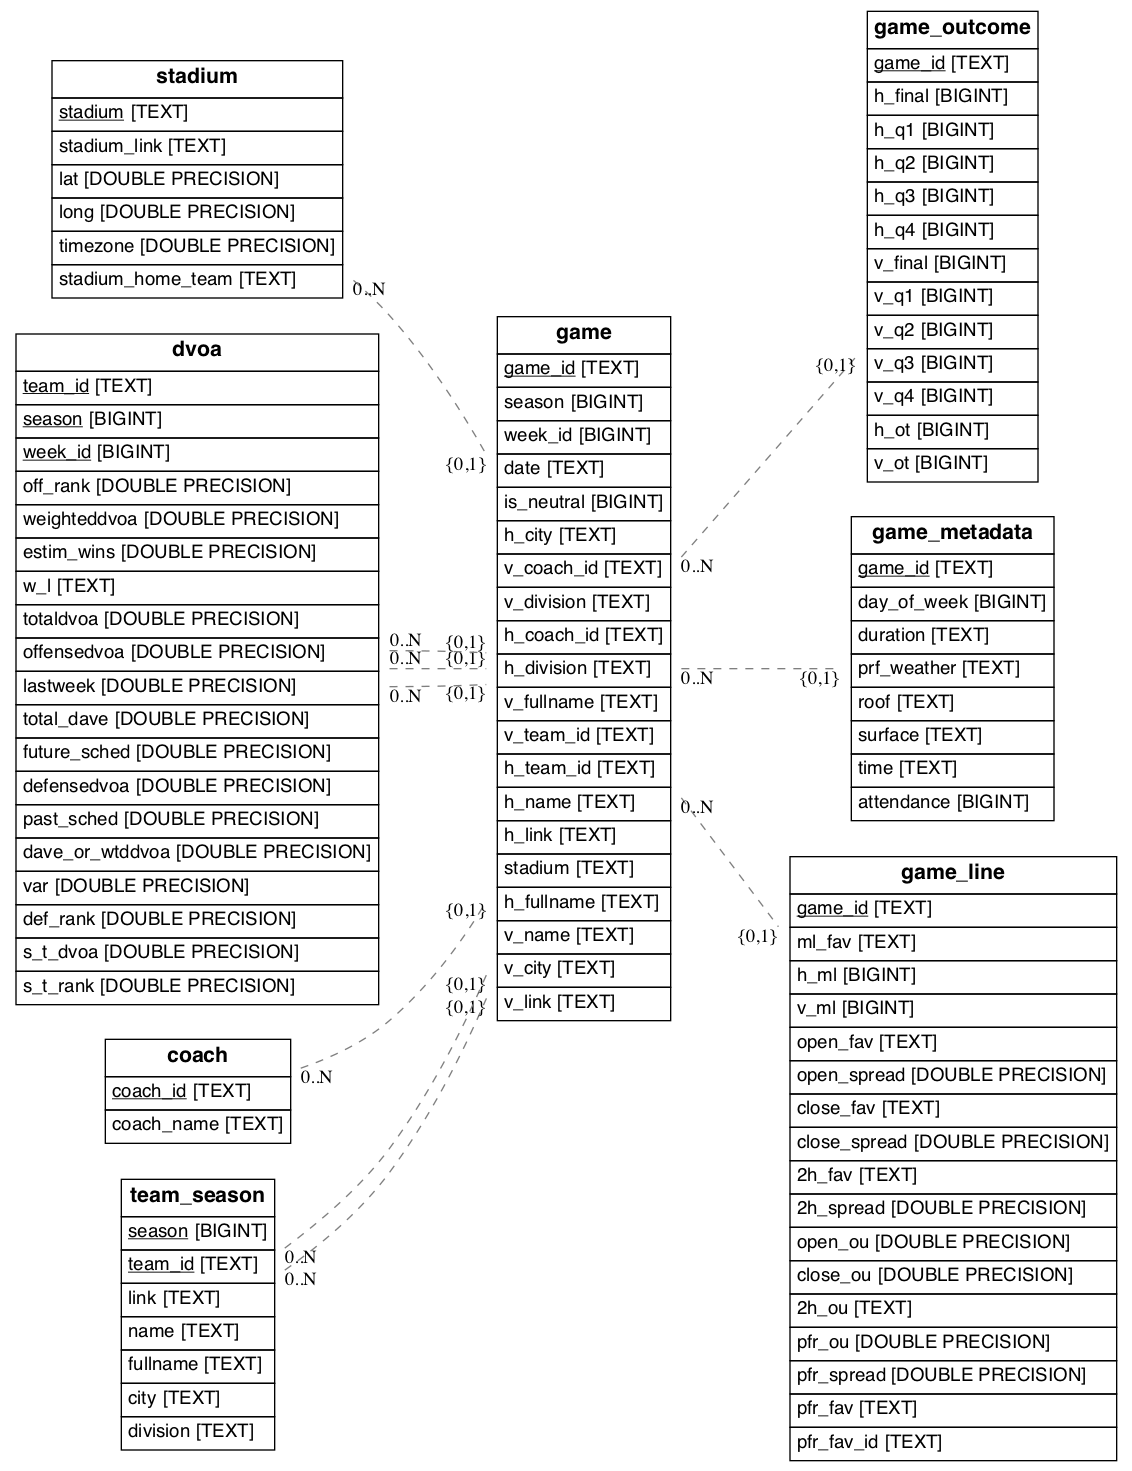

In [9]:
Image(filename='er_diagram.png') 